In [1]:
import sys 
print(sys.version)

3.10.11 (main, Apr 20 2023, 19:02:41) [GCC 11.2.0]


In [2]:
!conda list transformers

# packages in environment at /home/bread/anaconda3/envs/py31011:
#
# Name                    Version                   Build  Channel
transformers              4.28.1                   pypi_0    pypi


In [3]:
!pwd

/home/bread/A_prc/transformer


# Chapter 4. 다중 언어 개체명 인식

지금까지는 NLP 작업을 하기 위해 트랜스포머를 영어 말뭉치에 적용

다국어를 사용하고 싶을 때는 다중 언어 트랜스포머 모델이 도움을 줌

BERT처럼 이런 모델은 사전 훈련 목표로 마스크드 언어 모델링을 사용하지만 100개 이상의 언어로 된 텍스트에서 동시에 훈련함

다중 언어 트랜스포머는 많은 언어로 된 대규모 말뭉치에서 사전 훈련해서 **제로샷 교차 언어 전이(Zero-shot cross-lingual transfer)** 가 가능함

  - 한 언어에서 미세 튜닝된 모델이 추가 훈련없이 다른 언어에 적용된다는 의미!
  
  - 이런 모델은 한 대화에서 둘 이상의 언어나 사투리를 바꾸는 '코드 스위칭(code switching)'에 적합함

이 장에서는 XLM-RoBERTa 트랜스포머 모델을 개체명 인식(NER: Named Entity Recognition)을 수행하도록 여러 언어에서 미세 튜닝하는 방법을 알아보겠음

1장에서 보았듯이 NER은 텍스트에서 사람, 조직, 위치 같은 개체명을 식별하는 일반적인 NLP 작업으로 다양한 애플리케이션에 사용함

  - 가령, 회사 문서에서 중요한 정보를 추출하거나, 검색 엔진의 품질을 높이거나, 말뭉치에서 구조적인 데이터베이스를 만드는데 사용함
  
이 장에서는 네 개의 공용어(영어가 언어를 이어주는 다리 역할을 하는 경우가 많습니다.)를 사용하며, 스위스에서 주로 활동하는 고객을 위해 NER을 수행한다고 가정

**(NOTE)** **제로샷 전이(zero-shot transfer)** 또는 **제로샷 학습(zero-shot learning)** 은 일반적으로 한 레이블 집합에서 모델을 훈련한 다음 다른 레이블 집합에서 평가하는 작업을 의미함. 트랜스포머에서 제로샷 학습은 GPT-3 같은 언어 모델을 후속 작업에서 미세튜닝하지 않고 평가하는 상황을 의미하기도 함

> 
> **XLM(Cross-lingual Language Model)**: 다국어를 목표로 사전 학습 시킨 BERT를 교차 언어 모델(XLM)이라고 한다.
XLM은 단일 언어 및 병렬 데이터셋을 사용해 사전 학습된다. 병렬 데이터셋은 언어 쌍의 텍스트로 구성된다. 즉 ,2개의 다른 언어로 된 동일한 텍스트로 구성된다.
>
> 예를 들어 영어 문장이 있다고 가정하면 프랑스어처럼 다른 언어로 된 문장이 동시에 있다. 이 병렬 데이터셋을 교차 언어 데이터셋이라고 한다.
또한 XLM은 바이트 쌍 인코딩(BPE)를 사용하고 모든 언어에서 공유된 어휘를 사용한다.
>
> **XLM의 사전 학습 전략** : 
> XLM은 다음을 사용해 사전 학습한다.
> - 인과 언어 모델링(CLM) : (causal language modeling) 주어진 이전 단어셋에서 현재 단어의 확률을 예측하는 것
> 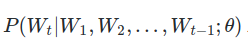
>
> - 마스크 언어 모델링(MLM): (masked language modeling) 무작위 마스킹 후 마크킹 된 토큰을 예측하도록 학습
> 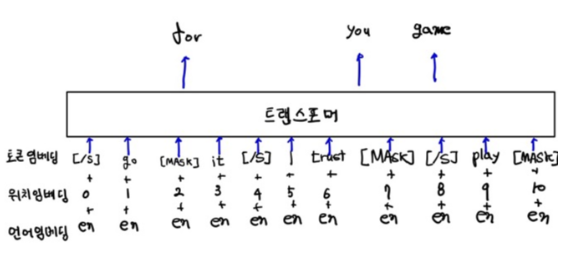
> 
> - 번역 언어 모델링(TLM): (translation language modeling) 서로 다른 두 언어로서 동일한 텍스트로 구성된 병렬 교차 언어 데이터 이용 모델 학습
> 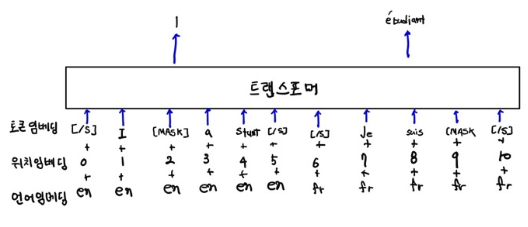
>
> 
> **[참고문헌]** https://ariz1623.tistory.com/309

## 4.1 데이터셋

이 장에서는 WikiANN 또는 **PAN-X**라 불리는 **교차 언어 전이 평가(Cross-lingual TRansfer Evaluation of Multilingual Encoders(XTREME))** 벤치 마크의 데이터를 사용함

이 데이터는 여러 언어의 위키피디아 문서로 구성되고 스위스에서 사용되는 독일어(62.9%), 프랑스어(22.9%), 이탈리아어(8.4%), 영어(5.8%) 네 개 언어로 작성됨

각 문서는 IOB2 포맷(Inside-Outside Beginning)으로 LOC(위치), PER(사람), ORG(조직) 태그가 표시되어 있음

이 포맷에서 B- 접두사는 개체명의 시작을 나타내고 동일한 개체명에 속해 연속되는 토큰에는 I- 접두사가 붙음.

  - 0 태그는 토큰이 어떤 개체명에도 속하지 않음을 나타냄
  
  - Jeff Dean is a computer scientist at Google in California 에 대한 IOB2 포맷으로 나타낸 시퀀스의 예
  
  | Tokens | Jeff | Dean  | is  | a  | computer  | scientist  | at   | Google  | in   | California  |
  |:-------|:-----|:------|:----|:---|:----------|:-----------|:-----|:--------|:-----|:------------|
  | **Tags**|B-PER |I-PER  | O   |O   |O          |O           |O     |B-ORG    |O     |B-LOC        |

XTREME에서 PAN-X 서브셋(subset) 중 하나를 로드하려면 load_dataset() 함수에 전달할 데이터셋 이름이 필요함

여러 서브셋이 포함된 데이터셋을 다룰 때 어떤 서브셋이 제공되는지 확인하려면 get_dataset_config_names() 함수를 호출

In [4]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME 서브셋 개수:  {len(xtreme_subsets)}")

XTREME 서브셋 개수:  183


서브셋이 많으므로 검색 범위를 좁혀 'PAN'으로 시작하는 서브셋을 찾음

In [5]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

-PAN-X 서브셋의 이름을 확인

ISO 639-1 언어 코드(https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes)로 보이는 두 문자로 된 접미사가 있음

독일어 말뭉치를 로드하려면 다음처럼 load_dataset() 함수의 name 매개변수에 독일어(de)에 해당하는 코드 전달


In [6]:
from datasets import load_dataset

load_dataset("xtreme", name = "PAN-X.de")

Found cached dataset xtreme (/home/bread/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

사실적인 스위스 말뭉치를 만들기 위해 스위스에서 사용되는 언어 비율로 PAN-X에서 독일어(de), 프랑스어(fr), 이탈리아어(it), 영어(en) 말뭉치를 샘플링

그러면, 언어가 불균형한 데이터셋이 만들어지는데 실제 데이터셋에서는 흔히 벌어지는 일

소수 언어에서 레이블링된 샘플을 구하려면 비용이 많이 들기도 함

소수 언어에 유창한 도메인 전문가가 드물기 때문

불균형한 이 데이터셋을 사용해 다중 언어 애플리케이션을 다룰 때 발생하는 일반적인 상황을 시뮬레이션하고, 모든 언어에서 작동하는 모델을 만드는 방법을 알아 봄

  - 각 언어를 추적하기 위해 파이썬 defaultdict 객체를 생성

  - 다음으로 언어 코드를 키로 하고 DatasetDict 타입의 PAN-X 말뭉치를 값으로 저장함

In [7]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

# 키가 없는 경우 DatasetDict를 반환
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # 다국어 말뭉치를 로드합니다.
    ds = load_dataset("xtreme", name = f"PAN-X.{lang}")
    # 각 분할을 언어 비율에 따라 다운샘플링하고 섞습니다. 
    for split in ds:
        panx_ch[lang][split] = (
            ds[split].shuffle(seed = 0).select(range(int(frac*ds[split].num_rows))))

Found cached dataset xtreme (/home/bread/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e5ddf09f1ae095ec.arrow
Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-25e7e2dd003d0fa6.arrow
Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-73a95bc0accfea8b.arrow
Found cached dataset xtreme (/home/bread/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-6ff29513007ec78b.arrow
Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-c5c9a4fc19dfd7d6.arrow
Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-9711ab25936b81b7.arrow
Found cached dataset xtreme (/home/bread/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-daa9a1770078307c.arrow
Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5e244c05031bab3c.arrow
Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-497ee15c12bff58d.arrow
Found cached dataset xtreme (/home/bread/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-757845faa9fa6949.arrow
Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-305cefc7ffa49fd9.arrow
Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e5ec5e6ba7c1237d.arrow


데이터셋에 의도하지 않은 편향이 들어가지 않도록 shuffle() 메서드를 사용

select() 메서드는 fracs 값을 따라 각 말뭉치를 다운 샘플링합니다. 

Dataset.num_rows 속성으로 훈련 세트에 언어마다 얼마나 많은 샘플이 들어 있는지 확인

In [8]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
            index = ["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


의도한 대로 독일어 샘플은 그 외 언어를 모두 합친 것보다 많음

이 데이터셋을 사용해 한 언어에서 미세 튜닝된 모델이 추가 훈련없이 다른 언어에 적용되는 제로샷 교차 언어 전이를 프랑스어, 이탈리아어, 영어에 수행

독일어 말뭉치에 있는 샘플 하나 확인

In [9]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


앞서 본 Dataset 객체와 마찬가지로, 이 샘플의 키는 애로우(arrow) 테이블의 열 이름에 해당하고 값은 각 열에 있는 항목

특히 ner_tags 열은 각 개체명이 매핑된 클래스 ID


In [10]:
# 이해하기 쉽도록 LOC, PER, ORG 태그에 새로운 열 생성
# Dataset 객체는 각 열의 데이터 타입을 담은 features 속성을 가짐

for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}:{value}")

tokens:Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags:Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs:Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


sequence 클래스는 이 필드가 특성 리스트를 담고 있음을 나타냄

ner_tags의 경우 ClassLabel의 리스트 

In [11]:
# 훈련세트의 특성 확인

tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


2장에서 본 ClassLabel.int2str() 메서드를 사용해 각 태그의 클래스 이름을 담은 새로운 열(ner_tags_str)을 훈련 세트에 추가

map() 메서드에 하나의 dict를 반환하는 함수를 적용 

이 딕셔너리의 키는 새로운 열 이름이고 값은 태그 클래스 이름의 List


In [12]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-f3309bc5e9d28268.arrow
Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-36ed4bdaca6e2a48.arrow
Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-a08bda4878cb6bac.arrow


이제 태그를 읽기 좋게 변환함

훈련 세트에 있는 첫 번째 샘플의 토큰과 태그 이름을 나란히 출력

In [13]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


'2,000 Einwohnern an der Danziger Bucht in der polnischen Woiwodschaft Pommern'는 

영어로 '2,000 inhabitants at the Gdansk Bay in the Polish voivodeship of Pomerania'임

 - 그단스크만(Gdansk Bay)은 발트해(Baltic Sea)에 있는 만이고 voivodeship은 폴란드의 행정구역을 의미하기 때문에 LOC 태그가 붙은 것이 이해됨

태크가 불균형하게 부여되지 않았는지 확인하기 위해 각 분할에서 개체명의 빈도를 계산

In [14]:
from collections import Counter

split2freqs = defaultdict(Counter)

for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
                
pd.DataFrame.from_dict(split2freqs, orient = "index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


PER, LOC, ORG 빈도 분포가 대체로 각 분할에서 동일

이 검증 세트와 테스트 세트는 NER 태그의 일반화 능력을 평가하는 데 적절하다고 판단

다음으로 인기 있는 다중 언어 트랜스포머를 몇 가지 살펴보고 **NER** (Named Entity Recognition) 작업을 어떻게 적용하는 지 확인

## 4.2 다중 언어 트랜스포머

다중 언어 트랜스포머의 훈련 과정과 아키텍처는 단일 언어 트랜스포머와 비슷

다만 사전 훈련에 사용하는 말뭉치가 여러 언어의 문서로 구성될 뿐

언어의 차이에 대한 정보가 명시적으로 제공되지 않아도 이렇게 구축한 언어 표현이 여러 언어의 다양한 후속 작업에 쉽게 일반화 

교차 언어 전이를 수행하는 이런 능력이 경우에 따라 단일 언어 모델과 비슷한 결과를 내므로 언어마다 별도의 모델을 훈련할 필요가 없음


NER에 대한 교차 언어 전이의 과정을 측정하기 위해 CoNL-2002(https://huggingface.co/datasets/conll2002)와 CoNLL-2003(https://huggingface.co/datasets/conll2003) 데이터 셋이 영어, 네덜란드어, 스페인어, 독일어를 위한 벤치마크로 많이 사용됨

이 벤치마크는 PAN-X와 동일하게 개체명이 LOC, PER, ORG 태그로 분류된 뉴스 기사로 구성됨

하지만 이 세 카테고리에 속하지 않는 개체명을 위해 MISC 레이블이 추가됨

다중 언어 트랜스포머 모델은 일반적으로 세 가지 방식으로 평가함

**(en)** 영어 훈련 데이터에서 미세 튜닝한 다음에 각 언어의 테스트 세트에서 평가

**(each)** 언어별 성능을 측정하기 위해 단일 언어의 테스트 세트에서 미세 튜닝하고 평가함

**(all)** 모든 훈련 데이터에서 미세 튜닝해 각 언어의 테스트 세트에서 평가함



NER 작업에 비슷한 평가 전략을 적용

ㅇ 먼저 평가할 모델 선택
 
  - 초기 다중 언어 트랜스포머 중 하나는 mBERT
  
  - 사전 훈련 목표가 BERT의 아키텍처와 동일하지만 사전 훈련 말뭉치에 다양한 언어의 위키피디아 문서가 추가되었고,
  
  - 이후 XLM-RoBERTAa(약칭 XLM-R)로 대체됨
  
ㅇ XLM-R은 사전 훈련 목표로 100개 언어에 대한 MLM만 사용함

  - 하지만 이전 모델에 비해 사전 훈련 말뭉치가 매우 큼
  
  - 각 언어의 위키피디아 덤프와 2.5 테라바이트의 커먼 크롤(common crawl) 웹 데이터를 사용
  
  - 이 말뭉치는 초기 모델에서 사용한 데이터보다 몇 배가 더 크며 위키피디아 문서가 적은 버마어(Bumese)나 스와힐리어 같은 희소 언어에 대한 성능을 크게 높임
  
ㅇ 모델명에 RoBERTa가 붙은 이유는 사전 훈련 방식이 단일 언어 모델 RoBERTa와 같기 때문

  - RoBERTa의 개발자는 BERT를 여러 측면에서 향상시킴
  
  - 특히 다음 문장 예측 작업을 제거하며 BERT의 성능을 크게 높임
  
  - XLM-R은 XLM에서 사용하는 임베딩도 제거하고 SentencePiece를 사용해 원시 텍스트를 직접 토큰화 함
  
ㅇ XLM-R이 다중 언어라는 특징 외에 두 모델의 큰 차이점은 어휘 사전의 크기 

  - 사용하는 토큰의 개수가 RoBERTa는 55,000개지만 XLM-R은 250,000개

## 4.3 XLM-R 토큰화

XLM-R은 다국어 NLU 작업에 잘 맞는 모델

WordPiece 토크나이저 대신 100개 언어의 텍스트에서 훈련된 SentencePiece라는 토크나이저 사용

SentencePiece를 WordPiece와 비교하기 위해서 허깅페이스 트랜스포머스로 BERT와 XLM-R의 토크나이저를 로드함

In [15]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

짧은 텍스트 시퀀스를 인코딩해서 각 모델이 사전 훈련 동안에 사용하는 특수 토큰을 확인

In [16]:
text = "Jack Sparrow loves New York!"

bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [17]:
print(bert_tokens)

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']


In [18]:
# 책에 나와 있는 표를 만들기 위해 shallow copy 실시

import copy

bert_tokens_add = copy.copy(bert_tokens)
bert_tokens_add.append("None")

print(bert_tokens_add)

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]', 'None']


In [19]:
print(xlmr_tokens)

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


In [20]:
pd.DataFrame({'bert_tokens' : bert_tokens_add, 'xlmr_tokens' : xlmr_tokens}).transpose() 

,0,1,2,3,4,5,6,7,8,9
bert_tokens,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
xlmr_tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


In [21]:
print(bert_tokens)

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']


BERT가 문장 분류 작업에 사용하는 `[CLS]`와 `[SEP]` 토큰 대신에, XLM-R은 `<s>`와 `</s>`를 사용해 시퀀스의 처음과 끝을 표시

  - 토큰화 마지막 단계에 추가됨

### 4.3.1 토큰화 파이프 라인

지금까지 토큰화를 다룰 때 문자열을 모델에 주입할 정수로 변환하는 연산으로만 여겼는데, 전적으로 옳은 것은 아님

자세히 들여다보면, 실제 전체 처리 파이프라인은 다음 그림처럼 네 개의 단계로 구성됨

> 정규화 > 사전 토큰화 > 토크나이저 모델 > 사후 처리

![그림4-1](image/chapter04_tokenizer-pipeline.png)

"Jack Sparrow loves New York!" 이란 예시 문장으로 각 처리 단계를 자세히 알아보고 그 효과를 확인

**정규화**

이 단계는 원시 문자열을 더 '깨끗하게' 만들기 위해 적용하는 일련의 연산에 해당함

대개 이런 연산에는 공백과 악센트가 붙은 문자를 제거하는 작업 등이 포함됨. 유니코드 정규화(https://unicode.org/reports/tr15/)는 많은 토크나이저에서 적용하는 또 다른 일반적인 정규화 연산이며, 같은 문자를 쓰는 여러 가지 방식을 처리함

같은 문자열(즉, 같은 추상 문자의 시퀀스)의 두 버전이 다르게 표시될 수 있음

NFC, NFD, NFKC, NFKD 같은 유니코드 정규화 방식은 같은 문자를 쓰는 여러 방식을 표준 형식을 대체함

  - NFC: Normalization Form Canonical Composition
  - NFD: Normalization Form Canonical Decomposition
  - NFKC: Normalization Form Compatibility Composition
  - NFKD: Normalization Form Compatibility Decomposition

(한글과 유니코드 참고문헌: https://gist.github.com/Pusnow/aa865fa21f9557fa58d691a8b79f8a6d)

정규화의 또 다른 방식은 소문자로 바꾸는 것.

모델이 소문자만 받을 것으로 기대한다면 이 기법을 사용해 어휘사전의 크기를 줄일 수 있음 -> tolower() 함수 같은 방법

  - 예시 문장은 "jack sparrow loves new york!" 형태가 됨

**사전 토큰화(pretokenization)**

이 단계는 텍스트를 더 작은 객체로 분할하며 훈련 마지막에 생성되는 토큰의 상한선을 제공함

사전 토큰화가 텍스트를 단어로 분할하고 최종 토큰은 이 단어의 일부가 된다고 생각하면 좋음

영어, 독일어, 많은 인도-유럽어족의 언어에서 문자열이 일반적으로 공백과 구두점을 기준 삼아 단어로 분할됨

예시 문장은 이 단계에서 `["jack", "sparrow", "loves", "new", "york", "!"]`로 변환됨

이런 단어는 파이프라인 다음 단계에서 **BPE(Byte-Pair Encoding)** 나 **유니그램(unigram)** 알고리즘을 사용해 부분단어(subword)로 분할하기 더 쉬움

하지만 단어로 분할하는 것이 항상 간단하고 확실한 연산인 것은 아님. 게다가 타당성 있는 연산도 아님

예를 들어 중국어, 일본어, 한국어 같은 언어에서 인도-유럽어족 단어와 같은 의미 단위로 기호를 모으면 똑같이 유효한 여러 그룹이 만들어지는 비결정적 연산이 됨

이 경우 텍스트를 사전 토큰화하는 대신 언어별 사전 토큰화 라이브러리를 사용하는 것이 좋음

**토크나이저 모델**

입력 텍스트 정규화와 사전 토큰화를 수행하고 난 후 토크나이저를 사용해 부분단어 분할 모델을 단어에 적용

토크나이저는 파이프라인에서 말뭉치로 훈련이 필요한 부분

(그렇지 않고 사전 훈련된 토크나이저를 사용한다면 이미 훈련된 상태로 볼 수 있음)

이 모델은 단어를 부분단어로 나눠 어휘사전의 크기와 OOV 토큰의 개수를 줄이는 역할을 함

부분 단어 토큰화 알고리즘에는 BPE, 유니그램, WordPiece 등이 있음. 

  - 예시 문장에 토크나이저 모델을 적용하면 `[jack, spa, rrow, loves, new, york, !]` 같이 됨
  
이 시점부터는 더 이상 문자열 리스트가 아닌 정수(입력ID) 리스트를 가지게 됨

책에서는 이해하기 쉽게 단어는 그대로 두고 따옴표를 삭제해 이런 정수 변환을 나타냄

**사후 처리**

토큰화 파이프라인의 마지막 단계로, 토큰 리스트에 부가적인 변환을 적용할 때도 있음

가령 입력 토큰 인덱스의 시퀀스 처음과 끝에 특수 토큰을 추가하는 경우

  - BERT 스타일의 토크나이저는 분류 토큰(CLS)과 분할 토큰(SEP)을 추가해 토큰 리스트는 `[CLS, jack, spa, rrow, loves, new, york, !, SEP]` 형태가 됨
  
  - 그 다음 모델에 이 시퀀스(책에 쓰인 토큰이 아니라 정수의 시퀀스)를 주입함
  
  > *CLS(classification token), SEP(seperation token)*

XLM-R과 BERT 비교로 돌아가면, SentencePiece는 사후 처리 단계에서 `[CLS]`와 `[SEP]` 대신 `<s>`와 `</s>`를 추가함
(편의상 그림 설명에는 계속 [CLS]와 [SEP] 사용)

그럼 SentencePiece 토크나이저가 특별한 이유를 알아보자

### 4.3.2 SentencePiece 토크나이저

SentencePiece 토크나이저는 유니그램이라는 부분단어 분할 방식을 기반으로 각 입력 텍스트를 유니코드 문자 시퀀스로 인코딩함


**(SentencePiece)** 의 특징

ㅇ SentencePiece가 악센트, 구두점에 대해 몰라도 되므로 이 특징은 다국어 말뭉치에 특히 유용

  - 일본어 등의 많은 언어에 공백 문자가 있지 않다는 사실도 몰라도 됨
  
ㅇ 공백 문자가 유니코드 기호 U+2581 또는 아래 1/4 블록 문자(lower one quater block character)라고도 하는 `_`할당된다는 것

  - 따라서 SentencePiece는 언어별 사전 토크나이저에 의존하지 않고 정확하게 시퀀스를 복원함

**비교**

이전 절의 예시 문장을 다시 보면 WordPiece는 'York'와 '!' 사이에 공백이 없다는 정보를 잃어버림. 이와 달리 SentencePiece는 토큰화된 텍스트에 공백을 보존하기 때문에 정확하게 원시 텍스트로 다시 변환됨



In [22]:
"".join(xlmr_tokens).replace(u"\u2581"," ")

'<s> Jack Sparrow loves New York!</s>'

이제 SentencePiece의 작동 원리를 이해했으니 간단한 샘플을 NER(Named Entity Recognition)에 적합한 형태로 인코딩하는 방법을 알아보겠음

먼저, 토큰 분류 헤드와 함게 사전 훈련된 모델을 로드

하지만 이 헤드를 허깅페이스 트랜스포머스에서 로드하지 않고 직접 작성 (허깅페이스 트랜스포머스 API를 자세히 살펴보면 모든 작업을 단 몇 단계로 처리할 수 있음)

## 4.4 개체명 인식을 위한 트랜스포머

2장에서 보았듯이, 텍스트 분류를 위해 BERT는 특수 토큰(CLS)로 전체 텍스트 시퀀스를 표현함. 아래 그림처럼 이 표현을 완전 연결 또는 밀집 층에 통과시켜 이산적인 레이블 값을 출력함

> **`[그림4-2]`** 시퀀스 분류를 위해 인코더 기반 트랜스포머 미세 튜닝
>
> ![그림4-2](image/chapter04_clf-architecture.png)

BERT와 그 외 인코더 기반 트랜스포머는 NER 작업에 비슷한 방식을 사용함

다만 모든 입력 토큰의 표현이 완전 연결 층에 주입되어 해당 토큰의 개체명을 인식함

이런 이유로 NER을 종종 토큰 분류 작업으로 생각하기도 함

> **`[그림 4-3]`** (전체 과정) 개체명 인식을 위해 인코더 기반 트랜스포머 미세 튜닝
>
> ![그림4-3](image/chapter04_ner-architecture.png)

하지만 토큰 분류 작업에서 부분단어를 어떻게 처리해야 할까? 예를 들어 [그림4-3]에서 이름 'Christina'는 부분단어 'Chr'와 '##ista'로 토큰화 됨. 이 중 어느 단어에 (아니면 두 단어 모두에) B-PER 레이블을 할당해야 하는가?

BERT 논문에서 저자들은 이 레이블을 첫 번째 부분단어(이 예에서 'Chr')에 할당하고 이어지는 부분단어(이 예에서 '##ista')는 무시함

  - 여기에서 이런 방식을 사용하고 무시한 부분 단어를 IGN으로 표시
  
  - 나중에 후처리 단계에서 첫 번째 부분단어의 예측 레이블을 후속 부분 단어로 쉽게 전파할 수 있음
  
  - '##ista' 부분 단어의 표현에 B-PER 레이블을 할당할 경우 IOB2 포맷을 위반
  
    + 다행히 XLM-R 아키텍처는 BERT와 동일한 RoBERTa를 기반으로 하므로 BERT에서 본 모든 아키텍처 특징이 XLM-R에도 있음

## 4.5 트랜스포머 모델 클래스

허깅페이스 트랜스포머스는 아키텍처와 작업마다 전용 클래스를 제공함

작업에 연관된 모델 클래스 이름은 `<ModelName>For<Task>` 형식을 따름

  - AutoModel 클래스를 사용하는 경우 `AutoModelFor<Task>`와 같음

허깅페이스 트랜스포머스는 기존 모델을 득정 작업에 맞춰 쉽게 확장 가능하도록 설계됨

사전 훈련된 모델에서 가중치를 로드하고 작업에 특화된 헬퍼 함수를 사용

아주 조금만 수고하면 특정 용도의 사용자 정의 모델을 만들 수 있음

### 4.5.1 바디와 헤드

허깅페이스 트랜스포머스의 다재다능한 능력은 `바디(body)`와 `헤드(head)`로 나뉜 모델 구조에서 나옴

  - 이 구조는 사전 훈련된 모델을 후속 작업에 맞게 바꿀 때 이미 봄
  
  - **(헤드)** 모델의 마지막 층이 후속 작업에 맞는 층으로 바뀌는데, 이 마지막 층이 모델의 헤드이며 작업에 특화됨

  - **(바디)** 모델의 나머지 부분을 바디라 함. 여기에는 작업에 특화되지 않은 토큰 임베딩과 트랜스포머 층이 포함됨
  
  - 이 구조는 허깅 페이스 트랜스포머 코드에도 반영됨
  
모델의 바디는 `BertModel` 또는 `GPT2Model` 같은 클래스로 구현되며 (바디에 있는) 마지막 층의 은닉 상태를 반환함

BertForMaskedLM 또는 BertForSequenceClassification 같이 작업에 특화된 모델은 `[그림 4-4]`처럼 베이스 모델을 사용하고 마지막 은닉 상태 위에 필요한 헤드를 추가함

> ![그림 4-4](image/chapter04_bert-body-head.png)
> 
> [그림 4-4] `BertModel` 클래스는 모델의 바디만 포함하고, `BertFor<Task>` 클래스는 바디와 작업 전용 헤드를 연결한 것

### 4.5.2 토큰 분류를 위한 사용자 정의 모델 만들기

XLM-R에 대한 사용자 정의 토큰 분류 헤드를 만드는 예제를 살펴봄

XLM-R은 RoBERTa와 모델 구조가 동일, RoBERTa를 베이스 모델로 사용하되 특화된 설정을 추가

먼저, XLM-R NER 태그를 표현할 데이터 구조가 필요함

  - 추측컨데 모델을 초기화할 설정 객체와 출력을 생성할 forward() 함수가 필요

In [23]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig
    
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # 모델 바디를 로드합니다. 
        self.roberta = RobertaModel(config, add_pooling_layer = False)
        # 토큰 분류 헤드를 준비
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # 가중치를 로드하고 초기화 합니다. 
        self.init_weights()
        
    def forward(self, input_ids = None, attention_mask = None, token_type_ids = None, labels = None, **kwargs):
        
        # 모델 바디를 사용해 인코더 표현을 얻습니다.
        outputs = self.roberta(input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids, **kwargs)
        
        # 인코더 표현을 헤드에 통과시킵니다. 
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        
        # 손실을 계산합니다. 
        loss = None
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
        # 모델 출력 객체를 반환합니다. 
        return TokenClassifierOutput(loss = loss, 
                                     logits = logits, 
                                     hidden_states = outputs.hidden_states, 
                                     attentions = outputs.attentions)       

2023-06-03 23:04:44.614819: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-03 23:04:44.639508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 23:04:44.977968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


config_class는 새로운 모델을 초기화할 때 표준 XLM-R 설정을 사용하도록 도와줌

  - config_class는 RobertaPreTrainedModel의 부모 클래스 PreTrainedModel의 클래스 변수
  
  - 이 변수에 모델 구조로 사용할 설정 클래스(PreTrainedConfig의 서브 클래스)를 지정함
  
super() 메서드로 RobertaPreTrainedModel 클래스의 초기화 함수를 호출함

  - 이 추상 클래스는 사전 훈련된 가중치의 초기화나 로딩을 처리함
  
그 다음 모델 바디 RobertaModel을 로드하고 드롭아웃층과 피드 포워드 층으로 구성된 분류 헤드를 추가함

add_pooling_layer = False로 지정해서 `[CLS]` 토큰에 해당하는 은닉 상태 외에 모든 은닉 상태가 반환되도록 함

  - add_pooling_layer의 기본값은 True로 첫 번째 토큰의 은닉 상태만 밀집 층과 활성화 함수에 통과시켜 출력함

마지막으로 RobertaPreTrainedModel 클래스에서 상속된 init_weights() 메서드를 호출해 가중치를 초기화 함

  - init_weights() 메서드는 PreTrainedModel 클래스에 정의되며 RobertaPreTrainedModel 클래스에 정의된 init_weights() 메서드를 사용해 층의 가중치를 초기화함. init_weights()를 직접 호출하는 대신 이 메서드 호출을 담당하는 post_init() 메서드를 사용하는 것이 좋음

### 4.5.3 사용자 정의 모델 로드하기

토큰 분류 모델을 로드할 준비를 마침

모델 이름 외에 몇 가지 정보를 추가해야 함

각 개체명을 레이블링하는데 사용할 태그, 각 태그를 ID로 매핑하는 딕셔너리와 그 반대로 매핑하는 디셔너리

이런 정보는 모두 ClassLabel 객체인 tags 변수의 names 속성을 사용해 매핑함

In [24]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

3장에서 본 AutoConfig 객체에 이런 매핑과 tags.num_classes 속성을 저장함

from_pretrained() 메서드의 키워드 매개변수로 전달해 기본값을 오버라이드 함


In [25]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels = tags.num_classes, 
                                         id2label = index2tag, 
                                         label2id = tag2index)

AutoConfig 클래스는 모델 구조의 청사진을 가짐

AutoModel.from_pretrained(model_ckpt)로 모델을 로드할 때 모델에 연관된 설정 파일이 자동으로 다운로드 됨

  - xlmr_config를 따로 전달하지 않으면, config_class 변수에 지정된 XLMRobertaConfig 클래스의 from_pretrained() 메서드를 호출해 (BERT 같은) 기본값이 지정된 설정 객체를 생성함
  
  
  - 하지만 클래스 개수나 레이블 이름 등을 수정하고 싶다면 커스터마이징하려는 매개변수로 이 설정 파일을 먼저 로드해야 함

이제 config 매개변수를 추가한 다음, 이전처럼 from_pretrained() 함수를 사용해 모델 가중치를 로드함

모델 클래스에 사전 훈련된 가중치를 로드하는 코드를 작성하지 않았지만, RobertaPreTrainedModel을 상속했으니 다음과 같이 로드할 수 있음

In [26]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config = xlmr_config).to(device))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifie

토크나이저와 모델을 바르게 초기화했는지 빠르게 확인하기 위해 개체명을 알고 있는 작은 시퀀스의 예측 결과를 확인

In [27]:
# 텍스트를 입력 ID로 변환

input_ids = xlmr_tokenizer.encode(text, return_tensors = "pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index = ["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


시작 `<s>`와 `<\s>` 토큰 ID는 각각 0과 2

마지막으로 모델에 입력 ID를 전달하고 argmax 함수로 토큰마다 확률이 가장 높은 클래스를 선택해 예측


In [28]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim = -1)
print(f"시퀀스에 있는 토큰 개수: {len(xlmr_tokens)}" )
print(f"출력 크기: {outputs.shape}")

시퀀스에 있는 토큰 개수: 10
출력 크기: torch.Size([1, 10, 7])


로짓의 크기는 `[batch_size, num_tokens, num_tags]`

즉, 각 토큰에는 일곱개의 NER 태그와 로짓이 주어짐 

사전 훈련된 모델의 예측 결과를 태그 이름으로 바꿔 토근과 함께 확인함

In [29]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index = ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC


예상한 대로 랜덤한 가중치를 가진 토큰 분류 층은 개선할 여지가 많음 

레이블링 된 데이터로 미세 튜닝해서 결과를 더 좋게 만들어 봄 

훈련을 시작하기 전, 나중을 위해 앞의 과정을 하나의 헬퍼 함수로 만들어 봄

In [30]:
def tag_text(text, tags, model, tokenizer):
    
    # 토큰을 준비함
    tokens = tokenizer(text).tokens()
    
    # 시퀀스를 입력 ID로 인코딩 함
    input_ids = xlmr_tokenizer(text, return_tensors = "pt").input_ids.to(device)
    
    # 가능한 일곱 개의 클래스에 대한 로짓을 출력함
    outputs = model(input_ids)[0]
    
    # argmax 함수로 토큰마다 가장 가능성이 높은 클래스를 선택함
    predictions = torch.argmax(outputs, dim = 2)
    
    # 데이터 프레임으로 변환함
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index = ["Tokens", "Tags"])

## 4.6 NER 작업을 위한 텍스트 토큰화 하기

하나의 샘플을 인코딩하고 처리하는 토크나이저와 모델을 준비했으므로 다음 단계는 미세 튜닝을 위해 XLM-R 모델에 전달할 전체 데이터셋을 토큰화하는 것

2장에서 보았듯이 허깅페이스 데이터 셋은 map() 연산으로 Dataset 객체를 빠르게 토크놯함

이를 위해 다음처럼 간단한 시그니처(signature)를 가진 함수를 정의

```python

function(examples: Dict[str, List]) -> Dict[str, List]

```

여기서 examples는 Dataset의 슬라이스 하나에 해당. 예를 들면 `panx_de['train'][:10]` 

XLM-R 토크나이저는 모델 입력을 위해 입력ID를 반환함

따라서 반환된 결과에 어텐션 마스크와 각 토큰에 어떤 NER 태그가 연관됐는지 인코딩하는 레이블 ID를 추가 

허깅페이스 트랜스포커스 문서(https://huggingface.co/docs/transformers/tasks/token_classification)에 언급된 방법을 따라 독일어 샘플 문장 하나를 사용해 어떻게 하는 지 알아 봄

먼저 평범한 리스트로 단어와 태그를 준비함

In [31]:
words, labels = de_example["tokens"], de_example["ner_tags"]

그다음 각 단어를 토큰화합니다. 토크나이저에 is_split_into_words 매개변수를 사용해 입력 문장이 이미 단어로 나뉘어 졌다는 사실을 전함

In [32]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words = True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index = ["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


이 예에서 토크나이저는 'Einwohnern'을 두 개의 부분단어 `'_Einwohner'와 'n'`으로 나눔

`'_Einwohner'` 만 B-LOC 레이블에 연결한다는 규칙을 따라야 하므로 첫 번째 부분단어 이후의 부분단어는 마스킹함

다행히 tokenized_input 객체에는 이 작업에 도움이 되는 word_ids() 메서드가 있음

In [33]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index = ["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


word_ids는 각 부분단어를 words 리스트에 있는 해당 단어의 인덱스에 매핑

따라서 첫 번째 부분 단어 `'_2,000'`는 인덱스 0 이고 `'_Einwohner'와 'n'`는 인덱스 1에 할당됨

`<s>`, `</s>` 같은 특수 토큰은 None에 매핑함

이런 특수 토큰과 부분단어의 레이블을 -100으로 설정해 훈련하는 동안 마스킹 처리함

In [34]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx
    
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index = index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


**(NOTE)** 부분단어 표현을 마스킹하기 위해 ID로 -100을 선택한 이유

파이토치에 있는 크로스 엔트로피 손실 클래스 `torch.nn.CrossEntropyLoss`의 `ignore_index` 속성 값이 -100 이기 때문에 

훈련하는 동안 이 인덱스는 무시됨. 따라서 연속된 부분단어에 해당하는 토큰을 무시하기 위해 이 인덱스를 사용함

레이블 ID와 토큰을 어떻게 정렬하는 지 살펴봄.

이제 이 로직을 감싼 함수를 하나 정의해서 전체 데이터 셋에 적용

In [35]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], 
                                     truncation = True,
                                     is_split_into_words = True)
    labels = []
    
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index = idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

각 분할을 인코딩하는 데 필요한 모든 요소를 준비.

분할에 대해 반복 수행할 함수 생성

In [36]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched = True, remove_columns = ['langs', 'ner_tags', 'tokens'])

이 함수를 DatasetDict 객체에 적용하면 분할마다 인코딩된 Dataset 객체를 얻음 

이 함수를 사용해 독일어 말뭉치를 인코딩

In [37]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-05a6e5bc581fb6ae.arrow
Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-4ba034e6b7d3d5da.arrow
Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-cd9dedc8808e02be.arrow


모델과 데이터셋을 준비했으니 이제 성능 지표를 정의

## 4.7 성능 측정

NER 모델 평가는 텍스트 분류 모델 평가와 비슷

일반적으로 정밀도(precision), 재현율(re-call), F1-score 결과를 보고함 

유일한 차이는 예측 하나를 정확하다고 판단하기 위해 한 개체명에 있는 모든 단어가 올바르게 예측되어야 한다는 점

다행히 이런 종류의 문제를 위해 라이브러리 seqeval(https://huggingface.co/spaces/evaluate-metric/seqeval / https://github.com/chakki-works/seqeval)이 고안됨

가령 NER 태그와 모델 예측 결과를 전달하면 seqeval의 classification_report() 함수를 통해 이런 지표를 계산함



In [38]:
from seqeval.metrics import classification_report

y_true = [["0", "0", "0", "B-MISC", "I-MISC", "I-MISC", "0"], ["B-PER", "I-PER", "0"]]
y_pred = [["0", "0", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "0"], ["B-PER", "I-PER", "0"]]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1
           _       0.00      0.00      0.00         1

   micro avg       0.33      0.33      0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3



/home/bread/anaconda3/envs/py31011/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


이렇게 seqeval은 리스트의 리스트로 구성된 예측과 레이블을 입력 받음

각 리스트는 검증 세트나 데트스 세트의 한 샘플에 해당함

이런 지표를 훈련 과정에 통합하려면 모델 출력을 seqeval이 기대하는 리스트로 변환하는 함수가 필요

이를 위해 다음처럼 연속된 부분 단어의 레이블 ID를 무시하는 함수를 만듦

In [39]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis = 2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        
        for seq_idx in range(seq_len):
            # 레이블 IDs = -100 무시 
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
                
        labels_list.append(example_labels)
        preds_list.append(example_preds)
    
    return preds_list, labels_list

성능 측정 준비 완료, 실제 모델 훈련 실시

## 4.8 XLM-RoBERTa 미세 튜닝하기

이제 모델을 미세 튜닝할 모든 요소를 갖춤

첫번째 전략은 PAN-X의 독일어 서브셋에 베이스 모델을 미세 튜닝하고 프랑스어, 이탈리아어, 영어에서 제로샷 교차 언어 성능을 평가

허깅페이스 트랜스포머스 Trainer를 사용해 훈련 루프를 처리함

따라서 먼저 TrainingArguments 클래스를 사용해 훈련 속성을 정의함

In [40]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
                    output_dir = model_name, 
                    log_level = "error", 
                    num_train_epochs = num_epochs,
                    per_device_train_batch_size = batch_size,
                    per_device_eval_batch_size = batch_size,
                    evaluation_strategy = "epoch",
                    save_steps = 1e6,
                    weight_decay = 0.01,
                    disable_tqdm=False,
                    logging_steps = logging_steps,
                    push_to_hub = True
    
                )

여기서는 에포크가 끝날 때마다 검증 세트에 대한 모델의 예측을 평가함

가중치 감쇠(weight decay) 값을 조정하고 체크 포인트를 저장하지 않도록 save_steps를 큰 수로 설정해 훈련 속도를 높임

In [41]:
# 허깅페이스 로그인 (터미널 사용 시 huggingface-cli login 사용)

from huggingface_hub import notebook_login
notebook_login()

참고: https://huggingface.co/settings/tokens 요기 사이트로 들어가서 확인

검증 세트에서 평가 지표를 어떻게 계산해야 하는지 Trainer로 전달함

따라서 앞서 정의한 align_predictions() 함수를 사용해 seqeval이 기대하는 형식에 맞춰 예측과 레이블을 추출해 F1-점수를 계산함

In [42]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    
    return {"f1": f1_score(y_true, y_pred)}

마지막으로 배치에서 가장 큰 시퀀스 길이로 입력 시퀀스를 패딩하도록 데이터 콜레이터(data colator)를 정의함

허깅페이스 트랜스포머스는 토큰 분류를 위해 입력과 레이블을 패딩하는 전용 데이터 콜레이터를 제공함

In [43]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

텍스트 분류 작업과 달리, 레이블도 시퀀스이기 때문에 레이블 패딩이 필수 

앞에서 보았듯, 레이블 시퀀스를 -100 으로 패딩해 파이토치 손실 함수가 무시하도록 만듬

  - DataCollatorForTokenClassification 클래스는 label_pad_token_id 매개변수에서 레이블을 패딩할 때 사용하는 ID를 지정.
  
  - 이 매개변수의 기본값은 -100

이 장에서 몇 개의 모델을 훈련하므로 Trainer를 위해 매번 새로운 모델을 만들지 않도록 model_init() 함수를 만듦

train() 메서드를 호출할 때 이 함수가 호출되어 훈련되지 않은 모델을 로드함

In [44]:
def model_init():
    return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config = xlmr_config).to(device))

In [45]:
# 인코딩된 데이터 셋과 함께 모든 정보를 Trainer에 전달

from transformers import Trainer

trainer = Trainer(model_init = model_init, 
                 args = training_args,
                 data_collator = data_collator,
                 compute_metrics=compute_metrics,
                 train_dataset=panx_de_encoded["train"],
                 eval_dataset=panx_de_encoded["validation"],
                 tokenizer = xlmr_tokenizer)

/home/bread/A_prc/transformer/xlm-roberta-base-finetuned-panx-de is already a clone of https://huggingface.co/youngbreadho/xlm-roberta-base-finetuned-panx-de. Make sure you pull the latest changes with `repo.git_pull()`.


다음처럼 훈련 루프를 실행하고 허브에 최종 모델을 업로드

In [46]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed")

/home/bread/anaconda3/envs/py31011/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.255500,0.168383,0.821669
2,0.128800,0.137871,0.846659
3,0.081200,0.141048,0.861372


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.
remote: Invalid username or password.
fatal: https://huggingface.co/youngbreadho/xlm-roberta-base-finetuned-panx-de/에 대한 인증이 실패하였습니다



OSError: remote: Invalid username or password.
fatal: https://huggingface.co/youngbreadho/xlm-roberta-base-finetuned-panx-de/에 대한 인증이 실패하였습니다


NER 모델에서 이 정도의 F-1 점수는 매우 좋은 편

기대한 대로 모델이 작동하는지 확인하기 위해 예시 문장의 독일어 번역을 테스트

In [47]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [48]:
# torch.cuda.empty_cache()

**(참고)** GPU out of memory 에러 발생 시 대처 법 

> PyTorch에서는 다중 GPU를 활용하기 위해 두 가지 주요한 모델 병렬화 기법을 제공합니다: torch.nn.DataParallel과 torch.nn.parallel.DistributedDataParallel입니다.
>
> torch.nn.DataParallel:
torch.nn.DataParallel은 가장 간단하고 일반적인 모델 병렬화 기법입니다. 단일 모델 인스턴스를 여러 GPU에 복제하여 데이터를 분할하고, 각 GPU에서 순전파 및 역전파를 병렬로 실행합니다. 이를 통해 GPU 메모리 부족 문제를 해결할 수 있습니다.
> 
> ```python
> import torch
> import torch.nn as nn
> 
> # 모델을 DataParallel로 래핑합니다.
> model = nn.DataParallel(model)
> 
> # 모델을 GPU로 이동합니다.
> model = model.to(device)
> 
> # 순전파 및 역전파 시에는 일반적인 방식으로 사용합니다.
> outputs = model(inputs)
> loss.backward()
> ```


> torch.nn.parallel.DistributedDataParallel:
> torch.nn.parallel.DistributedDataParallel은 여러 호스트에서 여러 GPU를 사용하는 분산 학습을 지원하는 모델 병렬화 기법입니다. 각 GPU의 모델 복제본이 데이터를 동기화하고 통신하는 방식으로 동작합니다. 여러 GPU 간의 통신은 torch.distributed 패키지를 사용하여 처리됩니다.
> 
> ```python
> import torch
> import torch.nn as nn
> import torch.distributed as dist
> from torch.nn.parallel import DistributedDataParallel
> 
> # 분산 학습을 위해 초기화합니다.
> dist.init_process_group(backend='nccl')
> 
> # 모델을 DistributedDataParallel로 래핑합니다.
> model = DistributedDataParallel(model)
> 
> # 모델을 GPU로 이동합니다.
> model = model.to(device)
> 
> # 순전파 및 역전파 시에는 일반적인 방식으로 사용합니다.
> outputs = model(inputs)
> loss.backward()
> ```
> 
> 이러한 모델 병렬화 기법은 여러 GPU에서 모델의 메모리 사용량을 분산시킴으로써 메모리 부족 문제를 완화할 수 있습니다. 선택한 방법은 환경과 요구사항에 > 따라 다를 수 있으므로 상황에 맞게 적절한 모델 병렬화 기법을 선택해야 합니다.

성공입니다. 하지만 단일 샘플로 수행한 성능 결과를 지나치게 확신해서는 안됩니다. 모델의 오류를 적절하고 자세하게 조사해야 합니다. 이 작업을 NER에서 어떻게 수행하는지는 다음절에서 알아보겠습니다.

## 4.9 오류 분석

XLM-R의 다중 언어 특징을 자세히 알아보기 전에 잠시 모델의 오류를 조사하겠습니다. 

2장에서 보았듯이 모델 오류의 철저한 분석은 트랜스포머스를 (그리고 일반적인 머신러닝 모델을) 훈련하고 디버깅할 대 중요합니다. 모델이 잘 작동하는 것처럼 보이지만, 심각한 결함이 있는 몇 가지 실패 유형이 있습니다. 

다음의 경우 훈련이 실패합니다. 


  - 우연히 너무 많은 토큰을 마스킹하고 일부 레이블도 마스킹하여 제대로 훈련되는 것처럼 손실이 감소합니다. 
  
  - compute_metrices() 함수에 실제 성능을 과대평가하는 버그가 있습니다. 
  
  - NER에 0 클래스 또는 0 개체명이 일반 클래스처럼 포함될 때가 있습니다. 압도적인 다수 클래스이므로 정확도와 F1 점수가 크게 왜곡될 것입니다. 

모델의 성능이 기대에 못 미칠 때 오류를 살펴보면, 유용한 통찰을 얻고 코드만 봐서는 찾기 힘든 버그를 발견할 수 있습니다. 
모델이 잘 작동하고 코드에 버그가 없더라도, 오류 분석은 모델의 강점과 약점을 파악하는 유용한 도구입니다. 
모델을 제품 환경에 배포할 때 이를 항상 유념하세요.

이 분석을 위해 앞서 소개한 강력한 방법 하나를 다시 사용하겠습니다. 

손실이 가장 큰 검증 샘플을 살펴보는 것입니다. 

2장에서 시퀀스 분류 모델을 분석할 대 만든 함수를 많이 재사용할 수 있습니다. 하지만 이번에는 샘플 시퀀스의 토큰마다 손실을 계산하겠습니다. 

검증 세트에 적용할 함수를 정의합니다.

In [49]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 리스트의 딕셔너리를 데이터 콜레이터에 적합한 딕셔너리의 리스트로 변환함
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]

    # 입력과 레이블을 패딩하고 모든 텐서를 장치에 배치합니다.
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # 데이터를 모델에 전달합니다. 
        output = trainer.model(input_ids, attention_mask)
        
        # logit.size: [batch_size, sequence_length, classes]
        # 마지막 축을 따라 가장 큰 로짓 값을 가진 클래스를 선택함
        predicted_label = torch.argmax(output.logits, axis = -1).cpu().numpy()
        
    # 배치 차원을 펼친 다음 토큰마다 손실을 계산함
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction = "none")
    
    # 배치 차원을 다시 만들고 넘파이 배열로 변환함
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    
    return {"loss":loss, "predicted_label": predicted_label }

이 함수를 map() 메서드를 사요ㅕㅇ해 전체 검증 세트에 적용하고 추가 분석을 위해 전체 데이터를 판다스 데이터 프레임으로 로드합니다.

In [50]:
valid_set = panx_de_encoded['validation']
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size = 32)
df = valid_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7fc93047c670> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-1c80317fa3b1799d.arrow


토큰과 레이블이 여전히 ID로 인코딩됐으니 결과를 알아보기 쉽게 토큰과 레이블을 다시 문자열로 변환

나중에 필터링에 사용하기 위해 -100인 패팅 토큰은 특별한 레이블인 IGN으로 할당

loss와 predicted_label을 입력과 같은 길이로 잘라서 패딩을 모두 제거함

In [51]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.010108822, 0.0, 0.010674875, 0.0088968...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [52]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.15,B-ORG,▁Luz
1,10,1,I-ORG,0.11,I-ORG,▁a


In [53]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # 멀티 컬럼을 삭제합니다.
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁(,▁),▁und,▁'',▁/,▁D
count,6066,1388,989,808,246,246,1171,2898,163,89
mean,0.04,0.1,0.12,0.15,0.35,0.34,0.07,0.03,0.46,0.62
sum,239.85,133.45,119.32,118.42,87.2,83.71,82.14,81.62,75.56,55.26


In [54]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.67,0.64,0.49,0.36,0.26,0.18,0.03
sum,974.86,1729.89,1889.77,1149.43,754.45,734.49,1432.58


In [55]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

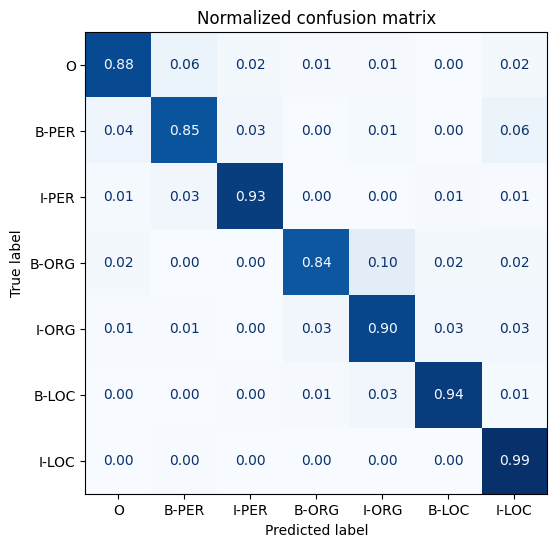

In [56]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [57]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,1.28,0.00,0.00,0.00,10.52,10.85,9.72,9.98,10.29,0.00,9.95,10.60,0.00,10.56,10.42,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.54,0.00,0.00,8.60,9.65,9.69,5.92,0.00,8.59,9.29,7.89,7.58,5.24,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.00,5.70,5.99,0.00,6.14,0.00,6.08,0.00,5.72,5.95,5.86,5.86,5.72,5.76,0.00


In [58]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.01,0.02,0.00,0.01,0.00


- 비교적 간단한 분석으로 모델과 데이터셋의 일부 약점을 찾아냄

- 실전에서는 이런 과정을 반복해 목표한 성능에 도달할 때까지 데이터셋을 정제하고, 모델을 다시 훈련하고, 새로운 오류를 분석함

- 한 언어에 대한 오류를 분석했지만 언어 간 성능에도 관심이 있습니다. XLM-R에서 교차 언어 전이가 얼마나 잘 수행되는지를 다음 절에서 몇 가지 실험으로 알아보겠습니다.

## 4.10 교차 언어 전이

독일어에서 XLM-R을 미세 튜닝 했으므로 Trainer 클래스의 predict() 메서드를 사용해 다른 언어로 전이되는 능력을 평가

  - 여러 언어 평가를 위해 헬퍼 함수 작성

In [59]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

이 함수를 사용해 테스트 세트의 성능을 평가하고 이 점수를 딕셔너리에 기록함

In [60]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"[de] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['de']:.3f}")

[de] 데이터셋에서 [de] 모델의 F1-점수: 0.865


NER 작업에서 괘 좋은 결과 

ORG 개체명이 훈련 데이터에서 가장 적고 많은 조직명이 XLM-R 어휘사전에 드물기 때문에 모델이 ORG 개체명에서 가장 큰 어려움을 겪는 것 같음

다른 언어 -> 독일어에서 미세 튜닝한 프랑스어 확인

In [61]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


나쁘지 않음! 

이름과 회사가 두 언어에서 같지만 모델은 'Kalifornien'의 프랑스어 번역 레이블을 정확하게 예측함

다음으로 전체 프랑스어 테스트 세트에서 독일어 모델의 성능을 계산 

  - 이를 위해 데이터셋을 인코딩하고 분류 리포트를 생성하는 간단한 함수를 작성

In [62]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"[fr] 데이터셋에서 [de] 모델의 f1-점수: {f1_scores['de']['fr']:.3f}")

Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-9b4a7822debd11ef.arrow


Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-24f57c1da9c941a3.arrow


[fr] 데이터셋에서 [de] 모델의 f1-점수: 0.697


마이크로 평균 점수로 15퍼센트 포인트가 감소했지만, 이 모델은 레이블링된 프랑스어 샘플을 하나도 본 적이 없음!

> - **마이크로(micro) 평균**은 클래스 레이블에 상관없이 전체 예측 결과를 사용해 점수를 계산
> 
> - **매크로(macro) 평균**은 각 클래스 레이블마다 계산한 점수를 평균함
>
> - **가중치(weighted) 평균**은 클래스 레이블마다 계산한 점수를 클래스별 샘플 수로 가중 평균함 
>
> seqeval의 f1_score() 함수는 클래스별 점수의 평균 방법을 지정하는 average 매개변수를 제공(기본값은 **'micro'**)

일반적으로 성능 감소의 폭은 언어 간 차이가 얼마나 큰지에 좌우됨

  - 독일어와 프랑스어는 인도-유럽어족 언어로 묶이지만, 기술적으로 보면 서로 다른 언어파인 게르만어파와 로망스어군에 각각 속함
  
다음으로 이탈리아어에서 성능을 평가해 봄

In [63]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"[it] 데이터셋에서 [de] 모델의 f1-점수: {f1_scores['de']['it']:.3f}")

Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-607a9a2ce338b7a0.arrow
Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-3f906431381ae50c.arrow
Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-13547f85e5e7c165.arrow


[it] 데이터셋에서 [de] 모델의 f1-점수: 0.656


마지막으로 게르만어파에 속하는 영어에서 성능을 평가함

In [64]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"[en] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['en']:.3f}")

Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-8976d63cc39b4b28.arrow
Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-4f47a989c4a9d7f1.arrow
Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-863cf54b362b6d9f.arrow


[en] 데이터셋에서 [de] 모델의 F1-점수: 0.590


놀랍게도, 모델 성능은 영어에서 가장 낮음

다음으로 언제 타깃 언어에서 직접 미세 튜닝을 해야 합리적인지 살펴봄

### 4.10.1 제로샷 전이가 유용할 때

이 절에서는 프랑스어 말뭉치로 훈련 세트의 크기를 증가시키면서 XLM-R을 미세 튜닝해 독일어 XLM-R로 교차 언어 전이한 것보다 나은 결과를 내는 훈련 세트 크기를 구함

이는 실제로 레이블링된 데이터를 더 많이 수집해야 하는지 판단하는데 유용함

간단하게 구성하기 위해 독일어 말뭉치에서 미세 튜닝할 대 사용한 하이퍼파라미터를 사용합니다. 

  - 다만 TrainingArguments의 logging_steps 매개변수는 훈련 세트 크기에 맞춰 조정

단일 언어 말뭉치에 해당하는 DatasetDict 객체를 받고 num_samples 만큼 샘플링해서 XLM-R 모델을 미세 튜닝한 다음, 최상의 에포크에서 얻은 점수를 반환하는 간단한 함수를 만듦

In [65]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size
    
    trainer = Trainer(model_init = model_init, 
                      args = training_args,
                      data_collator = data_collator, 
                      compute_metrics = compute_metrics,
                      train_dataset = train_ds, 
                      eval_dataset = valid_ds, 
                      tokenizer = xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

독일어 말뭉치 미세 튜닝에서 한 것처럼, 프랑스어 말뭉치를 입력ID, 어텐션 마스크, 레이블 ID로 인코딩함

In [66]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-1079bd5e960a25dd.arrow
Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-84be23e1848f8f38.arrow
Loading cached processed dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-24f57c1da9c941a3.arrow


그 다음 250개 샘플로 구성된 작은 훈련 세트에서 이 함수를 실행함

In [71]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-a13bcf6d0cfbf676.arrow


OutOfMemoryError: CUDA out of memory. Tried to allocate 734.00 MiB (GPU 0; 11.75 GiB total capacity; 8.30 GiB already allocated; 541.00 MiB free; 9.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [72]:
type(metrics_df)

NameError: name 'metrics_df' is not defined

In [73]:
metrics_df

NameError: name 'metrics_df' is not defined

샘플을 250개 사용할 때는 프랑스어에서 미세 튜닝한 성능이 독일어에서 제로샷 전이로 얻은 결과보다 크게 떨어짐

훈련 세트 크기를 500, 1000, 2000, 4000개로 늘려서 성능 향상을 확인함

In [74]:
import pandas as pd

for num_samples in [500, 1000, 2000, 4000]:
    temp_df = train_on_subset(panx_fr_encoded, num_samples)
    metrics_df = pd.concat([metrics_df, temp_df])

Loading cached shuffled indices for dataset at /home/bread/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-a13bcf6d0cfbf676.arrow


OutOfMemoryError: CUDA out of memory. Tried to allocate 734.00 MiB (GPU 0; 11.75 GiB total capacity; 8.30 GiB already allocated; 538.75 MiB free; 9.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [75]:
metrics_df

NameError: name 'metrics_df' is not defined

In [70]:
import torch

# CUDA 캐시 비우기
torch.cuda.empty_cache()

In [69]:
import torch

# 현재 할당된 CUDA 메모리 양
allocated_memory = torch.cuda.memory_allocated()
print(f"Currently allocated memory: {allocated_memory / 1024**2} MB")

# 최대 할당된 CUDA 메모리 양
max_allocated_memory = torch.cuda.max_memory_allocated()
print(f"Max allocated memory: {max_allocated_memory / 1024**2} MB")


Currently allocated memory: 8497.931640625 MB
Max allocated memory: 9245.1865234375 MB


In [ ]:
!nvidia-smi

In [68]:
import torch

# CUDA 메모리 요약 정보 출력
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   8497 MiB |   9245 MiB |   8642 GiB |   8633 GiB |
|       from large pool |   8488 MiB |   9235 MiB |   8389 GiB |   8381 GiB |
|       from small pool |      9 MiB |     59 MiB |    252 GiB |    252 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   8497 MiB |   9245 MiB |   8642 GiB |   8633 GiB |
|       from large pool |   8488 MiB |   9235 MiB |   8389 GiB |

NameError: name 'metrics_df' is not defined

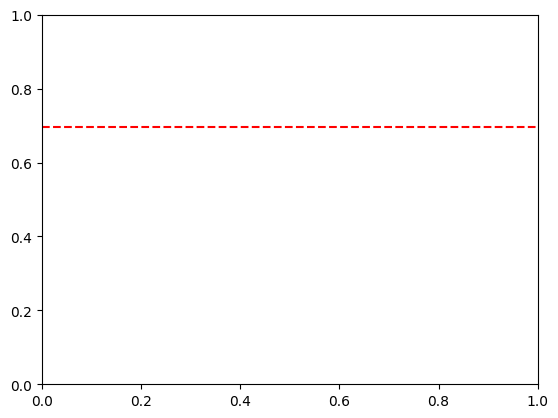

In [76]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

그래프를 보면, 훈련 샘플이 약 750개일 때까지 제로샷 전이가 앞섬. 그 후에는 프랑스어 미세 튜닝이 독일어에서 미세 튜닝한 대와 비슷한 수준으로 성능이 향상됨

하짐나 제로샷 전이를 무시해서는 안됨.

필자들의 경험에 비추어보면 도메인 전문가를 고용해 수백 개의 문서를 레이블링하는 비용은 만만치 않음 

특히 NER에서 레이블링 과정은 복잡하고 시간이 많이 걸림

다중언어 학습을 평가하는 마지막 방법은 동시에 미세 튜닝하는 것! 

이에 대해 알아보겠습니다.

### 4.10.2 다국어에서 동시에 미세 튜닝하기